In [1]:
import torch
import numpy as np
from torch import Tensor
import pandas as pd
import omegaconf

from matplotlib import rc_file
rc_file("../../matplotlibrc")

import sys
import os
__file__ = os.path.abspath('')
sys.path.append(os.path.join(os.path.dirname(__file__), '..'))

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns

from labproject.metrics.MMD import *

In [65]:
dist = torch.distributions.MultivariateNormal(torch.zeros(10), torch.eye(10))
phat1 = dist.sample((5000,))
phat2 = dist.sample((5000,))
p1 = dist.sample((5000,))

# add 1 to only the first dimension
p1[0] += 1



In [4]:
ws_hat = [.6,.4]
sds_hat = [1,2]
us_hat = [4,-6]

p1 = torch.distributions.Normal(us_hat[0], sds_hat[0]).sample((5000,))

u_hat = 0
sd_hat = np.sqrt(ws_hat[0]*sds_hat[0]**2 + ws_hat[1]*sds_hat[1]**2 +ws_hat[0]*us_hat[0]**2+ws_hat[1]*us_hat[1]**2-(ws_hat[0]*us_hat[0]+ws_hat[1]*us_hat[1])**2)

sd_1=sd_hat
u1 = 0

# Define the number of Gaussian components in the mixture
N = len(ws_hat)

# Define Bernoulli distributions for choosing between components
bernoulli_dists = [torch.distributions.Bernoulli(torch.tensor(weight)) for weight in ws_hat]

# Initialize an empty list to store samples from each component
gaussian_samples = []

# Sample a total of 1000 samples from the Gaussian mixture model
total_samples = 5000
samples_count = 0

while samples_count < total_samples:
    # Sample from each Bernoulli distribution to decide which component to sample from
    bernoulli_samples = [bernoulli_dist.sample() for bernoulli_dist in bernoulli_dists]

    # Sample from each Gaussian component based on the outcomes of the Bernoulli samples
    for i in range(N):
        if samples_count < total_samples:
            if bernoulli_samples[i].item() == 0:  # Sample from the ith Gaussian component
                gaussian_sample = torch.distributions.Normal(us_hat[i], sds_hat[i]).sample()
                gaussian_samples.append(gaussian_sample)
                samples_count += 1

# Convert the list of samples to a PyTorch tensor
gaussian_samples_tensor = torch.stack(gaussian_samples)

In [5]:
class Metric:
    def __init__(self, name: str, func: callable, **kwargs):
        self.name = name
        self.func = func
        self.kwargs = kwargs

    def __call__(self, x: Tensor, y: Tensor) -> Tensor:
        return self.func(x, y, **self.kwargs)
    

class DistComp:
    def __init__(self, dataset1: Tensor, dataset2: Tensor, metric: Metric, 
                 n_perms: int = 1, perm_size=1000, descr=""):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.metric = metric
        self.n_perms = n_perms
        self.perm_size = perm_size
        self.descr = descr

        columns = [metric.name]
        self.results_df = pd.DataFrame(np.nan, index=range(self.n_perms), columns=columns)

    def run_experiment(self):
        for i in range(self.n_perms):
            dataset2_perm = self.dataset2[torch.randperm(len(self.dataset2))[:self.perm_size]]
            dataset1_perm = self.dataset1[torch.randperm(len(self.dataset1))[:self.perm_size]]
            self.results_df.loc[i, self.metric.name] = self.metric(dataset1_perm, dataset2_perm).item()
    
    def reformat_df(self, data):
        """
        reformat the results_df to work with seaborn plot expectations.
        """
        metric = [column_name for _, row in data.iterrows() for column_name, _ in row.items()]
        split_ind = [i for i, _ in data.iterrows() for _ in range(len(data.columns))]
        distance = [value for _, row in data.iterrows() for _, value in row.items()]

        return pd.DataFrame({"metric": metric, "distance": distance, "split_ind": split_ind})
        

In [60]:
metrics = []
gammas = np.linspace(0.1, 10, 11)
for gamma in gammas:
    metrics.append(Metric(f'{gamma}', mmd_rbf, gamma=gamma))

datasets = [
    (gaussian_samples_tensor, gaussian_samples_tensor ),
    (gaussian_samples_tensor, p1),
]

descr_list = [r'$p_{true} - p_{true}$', r'$p_{true} - p_{1}$']

experiments = []

for metric in metrics:
    for dataset, descr in zip(datasets, descr_list):
        experiments.append(
            DistComp(dataset[0].unsqueeze(1), dataset[1].unsqueeze(1), metric, n_perms=1, perm_size=1000, descr=descr)
        )


for experiment in experiments:
    experiment.run_experiment()


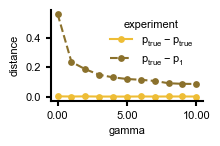

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def cm2inch(cm, INCH=2.54):
    if isinstance(cm, tuple):
        return tuple(i / INCH for i in cm)
    else:
        return cm / INCH

# Combine data from all experiments into a single dataframe
all_data = pd.concat([experiment.reformat_df(experiment.results_df).assign(experiment=experiment.descr) for experiment in experiments])

fig, ax = plt.subplots(figsize=cm2inch((5, 3)))

def generate_palette(hex_color, n_colors=5, saturation="light"):
    if saturation == "light":
        palette = sns.light_palette(hex_color, n_colors=n_colors, as_cmap=False)
    elif saturation == "dark":
        palette = sns.dark_palette(hex_color, n_colors=n_colors, as_cmap=False)
    return palette

col_dark = generate_palette("#eebd35", saturation='dark')[2]
col_light = generate_palette("#eebd35", saturation='light')[-1]

colors = [col_light, col_dark]

# Assign linestyles based on the experiment
linestyles = ['-', '--']  # solid line, dashed line

sns.pointplot(data=all_data, x="metric", y="distance", hue="experiment", ax=ax, palette=colors, linestyles=linestyles, linewidth=1.5)

# Format x-tick labels to show only the first two digits after the decimal point
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
ax.set_xticks(x_ticks[::5])
ax.set_ylabel('distance')
ax.set_xlabel('gamma')  
plt.savefig("gamma.pdf",bbox_inches='tight',transparent=True)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Combine data from all experiments into a single dataframe
all_data = pd.concat([experiment.reformat_df(experiment.results_df).assign(experiment=experiment.descr) for experiment in experiments[:24]])

fig, ax = plt.subplots(figsize=(10, 5))

# Assigning colors manually to each experiment
colors = ['blue', 'orange', 'green']

sns.pointplot(data=all_data, x="metric", y="distance", hue="experiment", ax=ax, palette=colors, linestyles="none")

ax.set_xlabel('metric')
ax.set_ylabel('distance')
ax.set_title('Comparison of Experiments')

plt.show()
